In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m atari_py.import_roms /content/drive/MyDrive/GT/DL/atari/roms

copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/assault.bin
copying asterix.bin from ROMS/Asterix (AKA Taz) (07-27-1983) (Atari, Jerome Domurat, Steve Woita) (CX2696) (Prototype).bin to /usr/local/lib/python3.7/dist-packages/a

In [10]:
import numpy as np
import torch
from torch import nn
from torch.distributions import Categorical
from torch.distributions.kl import kl_divergence
import torch.nn.functional as F
from torchvision.transforms import Resize
import gym
from torchvision.transforms.functional import resize


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Controls the stride.
        """
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU(),
        )
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, return_indices=True).to(device)

    def forward(self, x):
        x = self.block(x)
        # x = self.pool(x)
        return x

class Encoder(nn.Module):
    def __init__(self, device):
        super(Encoder, self).__init__()
        self.conv_blocks = (
            ConvBlock(3, 8, device),
            ConvBlock(8, 16, device),
            ConvBlock(16, 32, device),
            ConvBlock(32, 64, device),
            # ConvBlock(64, 128, device),
            # ConvBlock(128, 256, device),
        )
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        return self.flatten(x)
        # indices = []
        # for conv_block in self.conv_blocks:
            # x, idx = conv_block(x)
            # indices.append(idx)
        # return self.flatten(x), indices


class UnConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device):
        """
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Controls the stride.
        """
        super(UnConvBlock, self).__init__()

        # self.unpool = nn.MaxUnpool2d(kernel_size=3, stride=2)
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(in_channels).to(device),
            nn.ConvTranspose2d(
                in_channels, in_channels, kernel_size=3, padding=1, stride=1
            ).to(device),
            nn.ReLU(),
            nn.BatchNorm2d(in_channels).to(device),
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=3, padding=1, stride=1
            ).to(device),
        )

    def forward(self, x):
        # x = self.unpool(x, indices, output_size=shape)
        x = self.block(x)
        return x
    # def forward(self, x, indices, shape):
    #     x = self.unpool(x, indices, output_size=shape)
    #     x = self.block(x)
    #     return x


class Decoder(nn.Module):
    def __init__(self, n_hidden, n_cats, n_latent, n_square, device):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(n_hidden + n_cats, n_latent).to(device)
        self.unflatten = nn.Unflatten(1, [64, n_square, n_square])
        self.conv_blocks = (
            # UnConvBlock(256, 128, device),
            # UnConvBlock(128, 64, device),
            UnConvBlock(64, 32, device),
            UnConvBlock(32, 16, device),
            UnConvBlock(16, 8, device),
            UnConvBlock(8, 3, device),
        )
        # self.shapes = (
        #     (1, 512, 7, 7),
        #     (1, 256, 15, 15),
        #     (1, 128, 31, 31),
        #     (1, 64, 64, 64),
        #     (1, 64, 64, 64),
        # )
        # self.lin_block = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(3 * 64 * 64, 3 * 64 * 64),
        #     nn.Unflatten(1, (3, 64, 64)),
        # ).to(device)
        self.softmax = nn.Softmax(2)
    
    def forward(self, x):
        x = self.unflatten(self.linear(x))
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        # x = self.lin_block(x)
        x = self.softmax(x)
        return x
    # def forward(self, x, indices):
    #     x = self.unflatten(self.linear(x))
    #     for conv_block, idx, shape in zip(self.conv_blocks, reversed(indices), self.shapes):
    #         x = conv_block(x, idx, shape)
    #     x = self.lin_block(x)
    #     return x


class WorldModel(nn.Module):
    def __init__(
        self,
        device,
        n_hidden=400,
        n_cats=32,
        n_ff_hidden=1024,
        dropout=0.5,
        mix=0.8,
        kl_weight=0.5,
    ):
        super(WorldModel, self).__init__()
        self.dev = device
        self.n_hidden = n_hidden
        self.n_cats = n_cats
        self.n_ff_hidden = n_ff_hidden
        self.dropout = dropout
        self.mix = mix
        self.kl_weight = kl_weight
        self.resize = Resize((64, 64))
        self.encoder_model = Encoder(device).to(device)

        with torch.no_grad():
            test = torch.zeros((1, 64, 64, 3))
            self.n_latent = self.encoder_model(self.preprocess(test)).shape[1]
            # self.n_latent = self.encoder_model(self.preprocess(test))[0].shape[1]
            self.n_square = int(np.sqrt(self.n_latent / 64))

        self.decoder_model = Decoder(n_hidden, n_cats, self.n_latent, self.n_square, device).to(device)
        self.rssm = nn.GRUCell(n_cats + 1, n_hidden).to(device)
        self.posterior_model = nn.Sequential(
            nn.Linear(self.n_latent + n_hidden, n_ff_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_ff_hidden, n_cats * n_cats),
            nn.Unflatten(1, (n_cats, n_cats)),
            nn.Softmax(2),
        ).to(device)
        self.prior_model = nn.Sequential(
            nn.Linear(n_hidden, n_ff_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_ff_hidden, n_cats * n_cats),
            nn.Unflatten(1, (n_cats, n_cats)),
            nn.Softmax(2),
        ).to(device)
        self.reward_model = nn.Sequential(
            nn.Linear(n_hidden + n_cats, n_ff_hidden),
            nn.Dropout(dropout),
            nn.Linear(n_ff_hidden, 1),
        ).to(device)
        self.discount_model = nn.Sequential(
            nn.Linear(n_hidden + n_cats, n_ff_hidden),
            nn.Dropout(dropout),
            nn.Linear(n_ff_hidden, 1),
            nn.Softmax(1),
        ).to(device)

    def preprocess(self, img):
        img = torch.tensor(img).to(self.dev).permute([0, 3, 1, 2])
        return self.resize(img) / 255.0

    def get_real_states(self, img, hidden):
        prior = self.prior_model(hidden)

        std_img = self.preprocess(img)
        encoded_img = self.encoder_model(std_img)
        # encoded_img, indices = self.encoder_model(std_img)
        posterior = self.posterior_model(torch.cat((encoded_img, hidden), 1))

        posterior_dist = Categorical(posterior)
        posterior_sample = posterior_dist.sample().float()

        state = torch.cat((hidden, posterior_sample), 1)

        gen_img = self.decoder_model(state)
        # gen_img = self.decoder_model(state, indices)
        reward = self.reward_model(state)
        discount = self.discount_model(state)

        return prior, posterior, gen_img, std_img, reward, discount

    def get_next_hidden(self, hidden, dist, action):
        sample = Categorical(dist).sample()
        action = torch.tensor([[action]]).float().to(self.dev)
        return self.rssm(torch.cat((sample, action), 1), hidden)

    def get_dream_states(self, hidden, img=None):
        if img is None:
            posterior = self.prior_model(hidden)
        else:
            std_img = self.preprocess(img)
            encoded_img = self.encoder_model(std_img)
            # encoded_img, _ = self.encoder_model(std_img)
            posterior = self.posterior_model(torch.cat((encoded_img, hidden)))

        posterior_dist = Categorical(posterior)
        posterior_sample = posterior_dist.sample()

        state = torch.cat((hidden, posterior_sample), 1)

        reward = self.reward_model(state)
        discount = self.discount_model(state)

        return state, reward, discount

    def calc_loss(
        self,
        prior,
        posterior,
        gen_img,
        true_img,
        gen_reward,
        true_reward,
        gen_discount,
        true_discount,
    ):
        img_loss = F.binary_cross_entropy(gen_img, true_img)
        true_reward = torch.tensor([[true_reward]]).to(self.dev)
        true_discount = torch.tensor([[true_discount]]).to(self.dev)
        reward_loss = F.mse_loss(gen_reward, true_reward)
        discount_loss = F.binary_cross_entropy(gen_discount, true_discount)
        prior1 = Categorical(prior)
        prior2 = Categorical(prior.detach())
        posterior1 = Categorical(posterior.detach())
        posterior2 = Categorical(posterior)
        kl_div_loss = self.mix * kl_divergence(posterior1, prior1).mean() + (
            1 - self.mix
        ) * kl_divergence(posterior2, prior2).mean()
        return (
            img_loss + 0.2 * reward_loss + 0.1 * discount_loss + self.kl_weight * kl_div_loss,
            np.array((img_loss.detach().cpu().numpy(), reward_loss.detach().cpu().numpy(), discount_loss.detach().cpu().numpy(), kl_div_loss.detach().cpu().numpy(),)),
        )

In [20]:
import argparse
from collections import defaultdict
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import torch
from torch import nn, optim
from torch.distributions import Categorical
from torch.distributions.kl import kl_divergence
from torchvision.transforms import Resize
from torch.utils.tensorboard import SummaryWriter

# from world_model import WorldModel

seed = 5
env = gym.make("Pong-v0")
env.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
world_model = WorldModel(device)
optimizer = optim.Adam(world_model.parameters(), lr=0.001)

img = torch.tensor(env.reset()).unsqueeze(0)
# env.render()
total_reward = 0
total_loss = 0
total_losses = np.zeros(4)
check_iters = 500
avg_losses = []
for i in range(1, 100001):
    action = np.random.randint(env.action_space.n)
    next_img, true_reward, done, info = env.step(action)
    # env.render()
    true_discount = 0.999 if not done else 0.0
    next_img = torch.tensor(next_img).unsqueeze(0)
    total_reward += true_reward

    hidden = torch.zeros(1, world_model.n_hidden).to(device)
    prior, posterior, gen_img, std_img, reward, discount = world_model.get_real_states(img, hidden)
    hidden = world_model.get_next_hidden(hidden, posterior, action)
    loss, losses = world_model.calc_loss(prior, posterior, gen_img, std_img, reward, true_reward, discount, true_discount)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(world_model.parameters(), 1.0)
    optimizer.step()
    total_losses += losses

    total_loss += float(loss.detach().cpu())
    if i % check_iters == 0:
        avg_loss = total_loss / check_iters
        avg_losses_array = total_losses / check_iters
        print(
            f"Step {i}: Total Avg Loss: {avg_loss}, img_loss: {avg_losses_array[0]}, "
            f"reward_loss: {avg_losses_array[1]}, discount_loss: {avg_losses_array[2]},"
            f" kl_div: {avg_losses_array[3]}"
        )
        avg_losses.append(avg_loss)
        total_loss = 0
        total_losses = np.zeros(4)

    if done:
        print(f"Finished with score: {total_reward}")
        total_reward = 0
        img = torch.tensor(env.reset()).unsqueeze(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Step 500: Total Avg Loss: 5.907382582902908, img_loss: 1.4584908065795898, reward_loss: 19.488701261712222, discount_loss: 0.09999871253967285, kl_div: 1.082303167335689
Step 1000: Total Avg Loss: 2.1006303572654725, img_loss: 1.4293652546405793, reward_loss: 3.2326896075644806, discount_loss: 0.09999871253967285, kl_div: 0.02945464228815399
Finished with score: -20.0
Step 1500: Total Avg Loss: 1.9695443489551545, img_loss: 1.4269009804725648, reward_loss: 2.4527328613448716, discount_loss: 0.2997987151145935, kl_div: 0.04423385730118025
Step 2000: Total Avg Loss: 1.6541774096488953, img_loss: 1.4220073504447936, reward_loss: 1.058789432074741, discount_loss: 0.09999871253967285, kl_div: 0.0208246129869367
Finished with score: -21.0
Step 2500: Total Avg Loss: 1.6675036211013794, img_loss: 1.4214271953105926, reward_loss: 1.061969934187051, discount_loss: 0.2997987151145935, kl_div: 0.0074051399477466475
Step 3000: Total Avg Loss: 1.529678537607193, img_loss: 1.4206403663158418, reward_

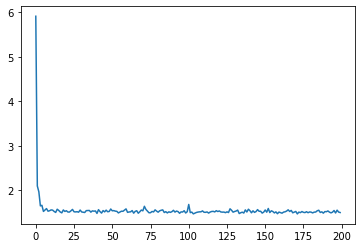

In [21]:
plt.plot(avg_losses)